In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi, isnan, isinf
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


In [2]:
# params : [mu, theta, omega_2, alpha, beta, m]
def beta_lag_wt_scheme(K, omega_2, omega_1 = 1):
    '''
    Function to generate an array of factor weights phis
    Args:
        K (int) : the number of lags.
        omega_1 (float, optional) : The first parameter of the weighting scheme. Defaults to 1.
        omega_2 (float) : The second parameter of the weighting scheme.

    Returns:
        ndarray: A column vector representing the weighting scheme.

    '''
    j_vec = np.arange(K,0,-1)
    denom =\
    (
        np
        .sum(
            (j_vec/(K+1)) ** (omega_1 - 1.0)
            * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
        )
    )

    numer =\
    (
        (j_vec/(K+1)) ** (omega_1 - 1.0)
        * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
    )

    return (numer / denom).reshape(j_vec.shape[0],1)
    
def get_onefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on one-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 6 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta, omega, m = params
    
    tau = m + theta * np.dot(X, beta_lag_wt_scheme(K, omega))
    
    T = tau.size

    return mu, alpha, beta, tau, T

def get_twofactor_tau(params, X, K):
    '''
    Function to return an array of taus based on two-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 8 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2, omega1, omega2, m = params
    X1, X2 = X
    
    tau =\
    (
        m 
        + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    )
    T = tau.size

    return mu, alpha, beta, tau, T

def get_threefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on three-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 10 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2,theta3, omega1, omega2, omega3, m = params
    X1, X2, X3 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau =\
    (
        m 
        + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
        + theta3 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    )
    T = tau.size

    return mu, alpha, beta, tau, T


def GARCH_MIDAS(params, returns, X, K, get_tau = get_onefactor_tau, full_output = False):
    '''
    Function representing the GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the parameters required for the model
        X (ndarray or tuple) : A set of matrices of the factor values. If there are more than one factor, a tuple is used.
        K (int) : The number of lags.
        get_tau (obj, optional) : The function required to get the required tau array. Defaults to one factor model, get_onefactor_tau
        full_output (bool, optional) : If True, it returns a set of outputs -loglik, logliks, e, tau, gt, ht, T. Otherwise, returns loglik. Defaults to False.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''

    mu, alpha, beta, tau, T = get_tau(params, X, K)

    ## define the squared errors
    e = returns[-tau.shape[0]:] - mu
    e2 = e**2
    e2 = e2.flatten()

    # define g
    gt = np.array([tau[0]])

    for t in range(1, tau.size):
        
        gt =\
            np.append(gt, 
                      (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
    
    gt = gt.reshape(-1,1)
    ht = np.multiply(tau,gt).flatten()

    # log likelihood
    logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
    
    if isnan(logliks.sum()) or isinf(logliks.sum()):
        loglik = 1E10
    else:
        loglik = logliks.sum()

    
    if full_output == True:
        return -loglik, logliks, e, tau, gt, ht, T

    else:
        return loglik



In [3]:
def hessian_matrix(fun, theta, args, epsilon=1e-05):
    '''
    Function to calculate the hessian matrix of the model.

    '''
    f = fun(theta, *args)
    h_ = epsilon*np.abs(theta)
    
    h = np.diag(h_)
    K = theta.shape[0]
    
    fp = np.zeros(K)
    fm = np.zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = np.zeros((K,K))
    fmm = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (np.diag(h))
    hh = hh.reshape((K,1))
    hh = np.dot(hh,hh.T)
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

def summary_stats(fun, T, params, args, labels, epsilon=1e-05):
    '''
    Function to calculate the p-values of the parameters given the model.

    '''
    H = hessian_matrix(fun, params, args, epsilon = epsilon)
    
    vcv = inv(H/T)/T
    eigenvalues, eigenvectors = np.linalg.eig(vcv)
    eigenvalues[eigenvalues < 0] = 0
    lambda_matrix = np.diag(eigenvalues)
    vcv = np.dot(np.dot(eigenvectors, lambda_matrix), np.linalg.inv(eigenvectors))

    se = np.diag(vcv)**0.5
    t = params/se
    pvalues = stats.t.sf(np.abs(t),args[0].size - params.shape[0])

    df =\
    (
        pd
        .DataFrame(
            data = {'values': params, 
                    'p-val': pvalues}, 
            index = labels
            ).T
    )

    return df

    


---

# Data Processing
- Read csvs containing CPU, EMDAT, Futures data

In [4]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('../data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('../data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('../data/natgas_futures_price.csv', sep=',')

In [5]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%Y-%m-%d')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1991-01-03,1.782,-2.767194,1991-01,101.211242,13
1991-01-04,1.743,-2.212856,1991-01,101.211242,13
1991-01-07,1.785,2.381065,1991-01,101.211242,13
1991-01-08,1.786,0.056007,1991-01,101.211242,13
1991-01-09,1.728,-3.301381,1991-01,101.211242,13


In [6]:
def get_realized_variance(data, target):
    factor =\
    (
        data[[target]]
        .resample('M')
        .agg(lambda x: (x ** 2).sum())
        .rename(columns = {target : 'realized_variance'})
    ).iloc[1:]

    return factor

def get_factors(data, target, K, fun = None):
    '''
    Function to derive the factor values required.

    Args:
        data (DataFrame) : The dataframe containing the original data.
        target (string) : The name of the target factor.
        K (int) : The number of lags.
        fun (obj, optional) : The function to use to derive the factor values. Defaults to None

    returns:
        ndarray : The derived matrix of factor values.
    '''
    if fun:
        factor = fun(data, target)
        target = 'realized_variance'

    else:
        temp =\
            np.log(
                data[[target]]
                .resample('M')
                .mean()
            )

        factor =\
        (
            temp - temp.shift()
        ).iloc[1:]  #* 100

    for i in range(1,K+1):
        factor[f'{target}_lag_{str(i).zfill(2)}'] =\
            factor[f'{target}'].shift(i)
        
    factor.dropna(inplace = True)
    factor['YYYY-MM'] = factor.index.to_period('M')

    X =\
    (
        np.array(
            data[['YYYY-MM']]
            .merge(factor,
                how = 'left',
                on = 'YYYY-MM')
            .dropna()
            .iloc[:,:1:-1]
        )
    )

    return X

In [7]:
def is_os_split(data, date, K):
    date = pd.to_datetime(date)
    train_data = data[data.index < date].copy()
    test_split =  date + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(K+1)
    test_data = data[data.index >= test_split].copy()

    X1_train = get_factors(train_data, 
                           'daily_return', 
                           K, 
                           fun = get_realized_variance)
    
    X1_test  = get_factors(test_data, 
                           'daily_return', 
                           K, 
                           fun = get_realized_variance)

    X2_train = get_factors(train_data, 'cpu_index', K)
    X2_test = get_factors(test_data, 'cpu_index', K)
    
    X3_train = get_factors(train_data, 'Monthly_Disaster_Freq', K)
    X3_test = get_factors(test_data, 'Monthly_Disaster_Freq', K)

    train_returns = np.array(train_data[['daily_return']])
    test_returns = np.array(test_data[['daily_return']])

    X_train = (X1_train, X2_train, X3_train)
    X_test = (X1_test, X2_test, X3_test)


    return X_train, X_test, train_returns, test_returns

    

In [8]:
# Get required split for lag = 36
X_36train, X_36test, train36_returns, test36_returns =\
    is_os_split(data, '2022-12-01', 36)

---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance

In [9]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 1, -2])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0], 36)) ## Limited Memory BFGS

results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.67259422295
        x: [ 5.606e-02  8.721e-02  8.995e-01  7.677e-02 -7.503e-02
            -1.978e+00]
      nit: 40
      jac: [-6.003e-02  8.517e-01  7.702e-01 -1.703e-01 -1.419e-02
            -3.234e-01]
     nfev: 448
     njev: 64
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

-18561.67259422295


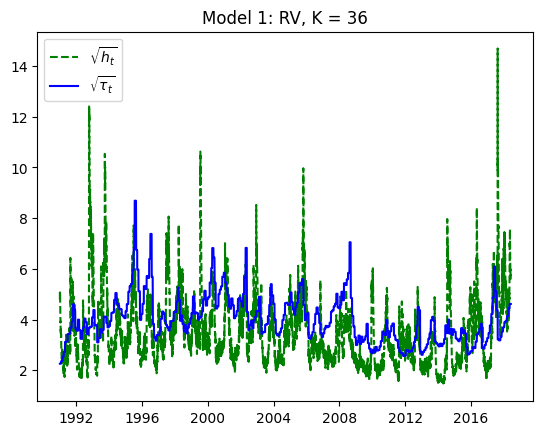

In [10]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results['x'], train36_returns, X_36train[0], 36, full_output=True)
print(loglik)
# Plot 
# Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 1: RV, K = 36')
plt.legend()
plt.show()

In [11]:
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (train36_returns, X_36train[0], 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.056057,8.721013e-02,0.899491,0.076772,-0.075030,-1.977517
p-val,0.043371,2.592237e-47,0.000000,0.000016,0.280188,0.218730


---
## Two-factors GARCH-MIDAS

Model 2: RV + CPU

In [12]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[:2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.672520373642
        x: [ 5.612e-02  8.721e-02  8.995e-01  7.677e-02  1.002e-01
            -7.501e-02  1.001e+00 -1.977e+00]
      nit: 36
      jac: [-4.729e-03  4.256e-02  5.348e-02  2.183e-02  2.183e-03
            -1.019e-02 -1.819e-02 -3.223e-01]
     nfev: 522
     njev: 58
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

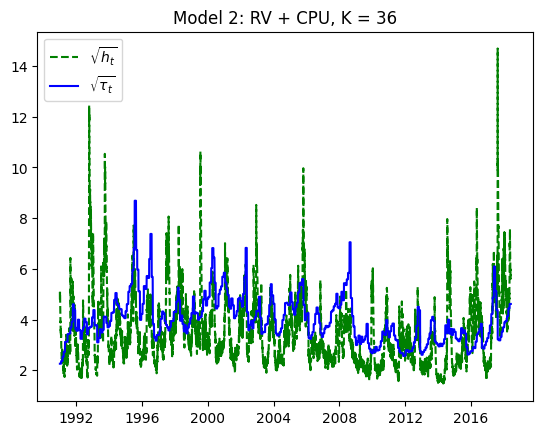

In [13]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], train36_returns, X_36train[:2], 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 2: RV + CPU, K = 36')
plt.legend()
plt.show()

In [14]:
summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (train36_returns, X_36train[:2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.056116,8.721184e-02,0.899487,0.076768,0.100215,-0.075009,1.000594,-1.976689
p-val,0.044830,2.103089e-47,0.000000,0.000013,0.416636,0.272262,0.407825,0.212443


Model 3: RV + EMDAT

In [15]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[::2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.667949022063
        x: [ 5.612e-02  8.721e-02  8.995e-01  7.676e-02  1.009e-01
            -7.498e-02  1.001e+00 -1.978e+00]
      nit: 47
      jac: [ 0.000e+00 -1.943e-01 -1.564e-01  8.768e-02 -4.620e-02
            -7.276e-03 -2.547e-02 -3.223e-01]
     nfev: 783
     njev: 87
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

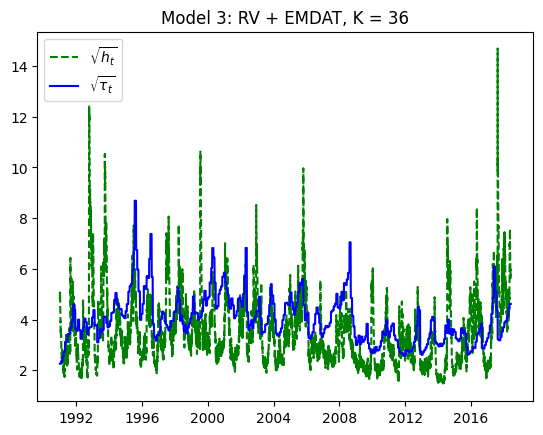

In [16]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], train36_returns, X_36train[::2], 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 3: RV + EMDAT, K = 36')
plt.legend()
plt.show()

In [17]:
summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (train36_returns, X_36train[::2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.056123,8.720828e-02,0.899487,0.076759,0.100856,-0.074978,1.000991,-1.977533
p-val,0.044732,2.566365e-47,0.000000,0.000020,0.429450,0.275388,0.376197,0.218408


---
## Three-Factors GARCH-MIDAS
Model 4: RV + CPU + EMDAT, K = 36

In [18]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, X_36train, 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results4

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.66795865925
        x: [ 5.617e-02  8.721e-02  8.995e-01  7.675e-02  1.002e-01
             1.009e-01 -7.494e-02  1.001e+00  1.001e+00 -1.977e+00]
      nit: 35
      jac: [ 4.657e-02 -5.384e-02 -2.692e-02 -4.184e-02  2.183e-03
            -4.584e-02 -4.729e-03 -1.783e-02 -2.510e-02 -3.227e-01]
     nfev: 605
     njev: 55
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

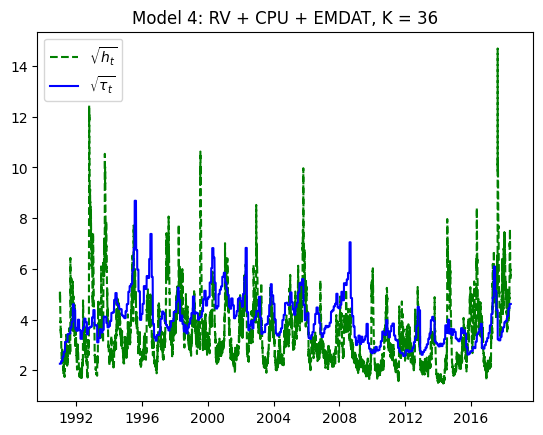

In [19]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], train36_returns, X_36train, 36, get_tau=get_threefactor_tau, full_output=True)

# Plot 
plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 4: RV + CPU + EMDAT, K = 36')
plt.legend()
plt.show()

In [20]:
summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (train36_returns, X_36train, 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.056173,8.720648e-02,0.899488,0.076752,0.100221,0.100867,-0.074936,1.000575,1.000993,-1.976955
p-val,0.046295,4.502574e-47,0.000000,0.000028,0.430398,0.435710,0.284306,0.380423,0.351269,0.227576


Model 5: RV + CPU + EMDAT, K = 33

In [21]:
# Get required split for lag = 33
X_33train, X_33test, train33_returns, test33_returns =\
    is_os_split(data, '2022-12-01', 33)

In [22]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train33_returns, X_33train, 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results5

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18745.86678098726
        x: [ 5.036e-02  9.345e-02  8.938e-01  7.364e-02  1.019e-01
             1.112e-01  2.798e-01  1.000e+00  9.988e-01 -1.937e+00]
      nit: 39
      jac: [-3.092e-02  3.016e-01  4.209e-01 -2.026e-01 -3.565e-02
            -1.684e-01 -8.076e-02 -6.912e-03  2.219e-02 -9.324e-01]
     nfev: 605
     njev: 55
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

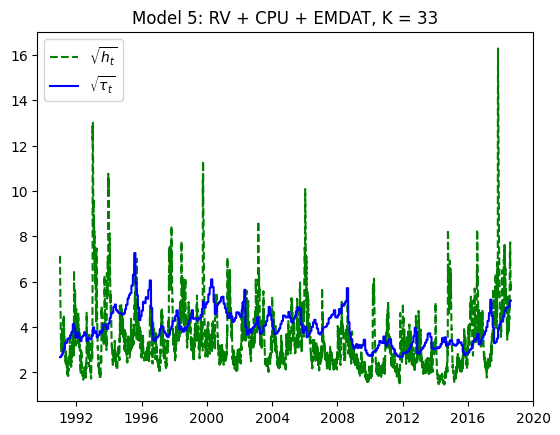

In [23]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], 
                                                  train33_returns, X_33train, 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)
date_array33 = pd.date_range(start=start_date, periods=T, freq='B')
# Plot 
plt.title('Model 5: RV + CPU + EMDAT, K = 33')
plt.plot(date_array33, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array33, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.legend()
plt.show()

In [24]:
summary_stats(GARCH_MIDAS, 
              T, 
              results5['x'], 
              (train33_returns, X_33train, 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.050359,9.344873e-02,0.893789,0.073639,0.101940,0.111187,0.279835,1.000160,0.998820,-1.936531
p-val,0.064680,1.783621e-47,0.000000,0.002522,0.441525,0.333011,0.034871,0.425204,0.015188,0.308947


---

## Out-sample Analysis

$$L_{MSE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}(\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}})^2$$

$$L_{MAE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}|\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}}|$$

In [25]:
df_realized_vol = pd.read_csv('../data/intraday_realized_volatility.csv', 
                              encoding_errors='ignore')

df_realized_vol.set_index('Date', inplace = True)
df_realized_vol.index = pd.to_datetime(df_realized_vol.index)

realized_vol = np.array(df_realized_vol.loc[df_realized_vol.index >= '2022-12-01', 'Volatility'])

In [26]:
def get_LMSE(N, vol, ht):
    e = vol/np.sqrt(252) - np.sqrt(ht)/100
    e2 = e**2

    return 1/(N) * np.sum(e2)

def get_LMAE(N, vol, ht):
    e = vol/np.sqrt(252) - np.sqrt(ht)/100
    abs_e = np.abs(e)

    return 1/N * np.sum(abs_e)

def out_sample_test(test_returns, vol, X_test, K, res, lookahead):
    if isinstance(X_test, list) or isinstance(X_test, tuple):
        M = len(X_test)-1
    else:
        M = 0
    
    func = [get_onefactor_tau, get_twofactor_tau, get_threefactor_tau]

    loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(res['x'], 
                                                  test_returns, 
                                                  X_test, 
                                                  K, 
                                                  get_tau=func[M], 
                                                  full_output=True)
    LMSE = []
    LMAE = []

    for N in lookahead:
       
        LMSE.append(get_LMSE(N, vol[:N], ht[:N]))
        LMAE.append(get_LMAE(N, vol[:N], ht[:N]))

    return LMSE, LMAE




In [27]:
LMSE1, LMAE1 = out_sample_test(test36_returns, realized_vol, X_36test[0], 36, results, [10,30,60,90,118])
LMSE2, LMAE2 = out_sample_test(test36_returns, realized_vol, X_36test[:2], 36, results2, [10,30,60,90,118])
LMSE3, LMAE3 = out_sample_test(test36_returns, realized_vol, X_36test[::2], 36, results3, [10,30,60,90,118])
LMSE4, LMAE4 = out_sample_test(test36_returns, realized_vol, X_36test, 36, results4, [10,30,60,90,118])
LMSE5, LMAE5 = out_sample_test(test33_returns, realized_vol, X_33test, 33, results5, [10,30,60,90,118])

In [28]:
pd.DataFrame({
    'MSE (RV, K = 36)' : LMSE1,
    'MAE (RV, K = 36)' : LMAE1,
    'MSE (RV + CPU, K = 36)' : LMSE2,
    'MAE (RV + CPU,, K = 36)' : LMAE2,
    'MSE (RV + EMDAT, K = 36)' : LMSE3,
    'MAE (RV + EMDAT, K = 36)' : LMAE3,
    'MSE (RV + CPU + EMDAT, K = 36)' : LMSE4,
    'MAE (RV + CPU + EMDAT, K = 36)' : LMAE4,
    'MSE (RV + CPU + EMDAT, K = 33)' : LMSE5,
    'MAE (RV + CPU + EMDAT, K = 33)' : LMAE5,
}, index = ['10 days forecast','30 days forecast','60 days forecast','90 days forecast', '118 days forecast']).T

,10 days forecast,30 days forecast,60 days forecast,90 days forecast,118 days forecast
"MSE (RV, K = 36)",0.016013,0.007015,0.003645,0.002451,0.001886
"MAE (RV, K = 36)",0.123864,0.071356,0.042787,0.030813,0.025166
"MSE (RV + CPU, K = 36)",0.016012,0.007015,0.003644,0.002451,0.001886
"MAE (RV + CPU,, K = 36)",0.123860,0.071352,0.042785,0.030811,0.025164
"MSE (RV + EMDAT, K = 36)",0.016005,0.007012,0.003643,0.002450,0.001885
"MAE (RV + EMDAT, K = 36)",0.123834,0.071336,0.042776,0.030805,0.025159
"MSE (RV + CPU + EMDAT, K = 36)",0.016002,0.007010,0.003642,0.002450,0.001885
"MAE (RV + CPU + EMDAT, K = 36)",0.123820,0.071329,0.042771,0.030802,0.025157
"MSE (RV + CPU + EMDAT, K = 33)",0.041862,0.018063,0.009169,0.006133,0.004698
"MAE (RV + CPU + EMDAT, K = 33)",0.200544,0.113313,0.063833,0.044713,0.035958


In [29]:
results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.67259422295
        x: [ 5.606e-02  8.721e-02  8.995e-01  7.677e-02 -7.503e-02
            -1.978e+00]
      nit: 40
      jac: [-6.003e-02  8.517e-01  7.702e-01 -1.703e-01 -1.419e-02
            -3.234e-01]
     nfev: 448
     njev: 64
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

### MCS
Reference: https://github.com/JLDC/model-confidence-set

In [30]:
import numpy as np
import pandas as pd
import warnings
from numba import njit

from tqdm import tqdm
from typing import Optional, Union

def default(x, default):
    return default if x is None else x

def stationary_bootstrap(n: int, n_boot: int, block_len: int):
    p = 1.0 / block_len
    for _ in range(n_boot):
        indices = np.zeros(n, dtype=np.int32)
        indices[0] = int(np.random.random() * n)
        select = np.random.random(n) < p
        indices[select] = (np.random.random(select.sum()) * n).astype(np.int32)
        for t in range(1, n):
            if not select[t]:
                indices[t] = indices[t - 1] + 1
        # Wrap around
        indices[indices > n - 1] -= n
        yield indices

def block_bootstrap(n: int, n_boot: int, block_len: int):
    for _ in range(n_boot):
        indices = np.zeros(n, dtype=np.int32)
        indices[0] = int(np.random.random() * n)
        counter = 0
        for t in range(1, n):
            counter = (counter + 1) % block_len
            if counter == 0:
                indices[t] = int(np.random.random() * n)
            else:
                indices[t] = indices[t - 1] + 1
        # Wrap around
        indices[indices > n - 1] -= n
        yield indices

def pval_R(z: np.ndarray, z_data: np.ndarray) -> float:
    TR_dist = np.abs(z).max(axis=(1, 2))
    TR = z_data.max()
    return (TR_dist > TR).mean()

def pval_SQ(z: np.ndarray, z_data: np.ndarray) -> float:
    dist = (z ** 2).sum(axis=(1, 2)) / 2
    return (dist > ((z_data ** 2).sum() / 2)).mean()

class ModelConfidenceSet:
    """
    A class for conducting the Model Confidence Set (MCS) procedure by Hansen, Lunde,
    and Nason (2011), which evaluates and compares the performance of multiple 
    predictive models based on their loss functions. The MCS provides a set of models 
    that are statistically indistinguishable from the best model at a given 
    confidence level.

    The MCS method is a statistical tool used for model selection and comparison,
    offering a way to identify a subset of models that are not significantly worse
    than the best model, according to their predictive accuracy or loss.

    Parameters
    ----------
    losses : np.ndarray or pd.DataFrame
        An array or DataFrame of shape (n_samples, n_models) containing the loss values
        associated with each model. Each column represents a model, and each row represents
        a loss value for a particular instance.
    n_boot : int, optional
        The number of bootstrap replications to use in the MCS procedure. Default is 5000.
    alpha : float, optional
        The significance level for determining the confidence set. Must be between 0 and 1.
        Default is 0.05.
    block_len : int, optional
        The length of blocks to use in block bootstrap methods. If None, it defaults to
        the number of observations. Only applicable if bootstrap_variant is "block".
    bootstrap_variant : {'stationary', 'block'}, optional
        The type of bootstrap to use. "stationary" for stationary bootstrap, and "block"
        for block bootstrap. Default is "stationary".
    method : {'R', 'SQ'}, optional
        The method to compute p-values. "R" for the Romano-Wolf method, and "SQ" for
        the sequential method. Default is "R".
    show_progress : bool, optional
        If True, shows a progress bar during the bootstrap computation and MCS procedure.
        Default is False.

    Attributes
    ----------
    included : np.ndarray
        An array of model indices that are included in the model confidence set at the
        specified alpha level.
    excluded : np.ndarray
        An array of model indices that are excluded from the model confidence set.
    pvalues : np.ndarray
        The p-values associated with each model, used to determine inclusion in the MCS.
    results : dict
        A dictionary containing the p-values and status (included/excluded) for 
        each model. If compute() has not been called, results will be None.

    Methods
    -------
    compute():
        Executes the MCS procedure, computing the set of models that are statistically
        indistinguishable from the best model.
    results() -> pd.DataFrame:
        Returns a DataFrame with the p-values and status (included/excluded) for each
        model, indexed by model names. If compute() has not been called, it will be
        executed before returning the results. If as_dataframe is False, 
        returns a dictionary.

    Examples
    --------
    >>> import numpy as np
    >>> losses = np.random.rand(100, 3)  # Simulated loss data for 3 models over 100 samples
    >>> mcs = ModelConfidenceSet(losses, n_boot=1000, alpha=0.05, show_progress=True)
    >>> mcs.compute()
    >>> results = mcs.results()
    >>> print(results)

    Notes
    -----
    The MCS procedure assumes that lower loss values indicate better model performance.
    Ensure that your loss function is consistent with this assumption.
    """

    def __init__(self, losses: np.ndarray, n_boot: int=5_000, 
                 alpha: float=0.05, block_len: Optional[int]=None, 
                 bootstrap_variant: str="stationary", method: str="R",
                 show_progress: bool=False) -> None:
    
        # Input validation
        if not (0 < alpha < 1):
            raise ValueError("alpha must be between 0 and 1")
        if losses.ndim != 2:
            raise ValueError("losses must be 2-dimensional")
        if losses.shape[1] <= 1:
            raise ValueError("losses must have more than one column (models)")
        if n_boot <= 0:
            raise ValueError("n_boot must be positive")
        block_len = default(block_len, losses.shape[0])
        if block_len <= 0:
            raise ValueError("block_len must be positive")
        if block_len > losses.shape[0]:
            raise ValueError("block_len must be smaller than the number of rows")
        if bootstrap_variant not in ("stationary", "block"):
            raise ValueError("bootstrap_variant must be one of 'stationary' or 'block'")
        if method not in ("R", "SQ"):
            raise ValueError("method must be one of 'R' or 'SQ'")
        if n_boot < 1_000:
            warnings.warn("n_boot is less than 1,000, which may lead to inaccurate results")
        if not isinstance(show_progress, bool):
            raise ValueError("show_progress must be a boolean")
        
        if isinstance(losses, pd.DataFrame):
            self.model_names = losses.columns
            self.losses = losses.values
        else:
            self.model_names = np.arange(1, losses.shape[1] + 1)
            self.losses = losses
        self.alpha = alpha
        self.n_boot = n_boot
        self.block_len = block_len
        self.bootstrap = stationary_bootstrap if bootstrap_variant == "stationary" else block_bootstrap
        self.bootstrap(2, 1, 1) # Run once for numba compilation
        self.pval_fn = pval_R if method == "R" else pval_SQ
        self.show_progress = show_progress
        
        self.included = None
        self.excluded = None
        self.pvalues = None

    def compute(self) -> None:
        n, m0 = self.losses.shape
        mloss = self.losses.mean(axis=0, keepdims=True)
        dij_bar = mloss - mloss.T

        # Run bootstrap
        dij_bar_boot = np.zeros((self.n_boot, m0, m0))
        itr = enumerate(block_bootstrap(n, self.n_boot, self.block_len))
        if self.show_progress:
            itr = tqdm(itr, total=self.n_boot, desc="Bootstrapping")

        for i, bi in itr:
            bloss = self.losses[bi, :].mean(axis=0, keepdims=True)
            dij_bar_boot[i, ...] = bloss - bloss.T

        # Compute bootstrapped standard deviation estimates
        dij_std = np.sqrt(np.mean((dij_bar_boot - dij_bar) ** 2, axis=0) + np.eye(m0))

        z0 = (dij_bar_boot - dij_bar) / dij_std
        z0_data = dij_bar / dij_std

        excluded = np.zeros(m0)
        pvals = np.ones(m0)
        models = np.arange(1, m0 + 1)

        itr = range(m0 - 1)
        if self.show_progress:
            itr = tqdm(itr, desc="Computing MCS", unit="model")

        for i in itr:
            included = np.setdiff1d(models, excluded) - 1
            m = len(included)
            scale = m / (m - 1)
            pvals[i] = self.pval_fn(
                z0[:, *np.ix_(included, included)], 
                z0_data[np.ix_(included, included)])
            
            # Compute model to remove
            di_bar = np.mean(dij_bar[np.ix_(included, included)], axis=0) * scale
            di_bar_boot = dij_bar_boot[:, *np.ix_(included, included)].mean(axis=1) * scale
            di_std = np.sqrt(np.mean((di_bar_boot - di_bar) ** 2, axis=0))
            t = di_bar / di_std
            excluded[i] = included[np.argmax(t)] + 1

        # MCS p-values are the max up to that point
        pvals = np.maximum.accumulate(pvals)
        # Add last model
        excluded[-1] = np.setdiff1d(models, excluded)[-1]

        # Included models are where pval >= alpha
        self.included = excluded[pvals >= self.alpha]
        self.excluded = excluded[pvals < self.alpha]
        self.pvalues = pvals

    def results(self, as_dataframe=True) -> Union[dict, pd.DataFrame]:
        if self.included is None:
            self.compute()
        
        idx = np.concatenate([self.excluded, self.included]).astype(int) - 1

        self.results = {
            "pvalues": self.pvalues,
            "status": np.where(self.pvalues >= self.alpha, "included", "excluded"),
            "models": self.model_names[idx]
        }
        if as_dataframe:
            df = pd.DataFrame(self.results)
            df.index = df.pop("models")
            return df
        else:
            return self.results

In [145]:
def get_SE(N, vol, ht):
    e = vol/np.sqrt(252) - np.sqrt(ht)/100
    e2 = e**2

    return e2

def get_AE(N, vol, ht):
    e = vol/np.sqrt(252) - np.sqrt(ht)/100
    abs_e = np.abs(e)

    return abs_e

def mcs_test(test_returns, vol, X_test_K_res_tuple, lookahead):

    SE = []
    AE = []
    
    for (X_test,K,res) in X_test_K_res_tuple:
    
        if isinstance(X_test, list) or isinstance(X_test, tuple):
            M = len(X_test)-1
        else:
            M = 0
    
        func = [get_onefactor_tau, get_twofactor_tau, get_threefactor_tau]

        loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(res['x'], 
                                                          test_returns, 
                                                          X_test, 
                                                          K, 
                                                          get_tau=func[M], 
                                                          full_output=True)

        SE.append(get_SE(lookahead, vol[:lookahead], ht[:lookahead]))
        AE.append(get_AE(lookahead, vol[:lookahead], ht[:lookahead]))

    SE= np.array(SE).transpose()
    AE= np.array(AE).transpose()
    
    mcs_mse = ModelConfidenceSet(SE, n_boot=1000, alpha=0.1, show_progress=True)
    mcs_mse.compute()
    mcs_mse_results = mcs_mse.results()
    
    mcs_mae = ModelConfidenceSet(AE, n_boot=1000, alpha=0.1, show_progress=True)
    mcs_mae.compute()
    mcs_mae_results = mcs_mae.results()    
    
        
    return mcs_mse_results,mcs_mae_results

In [152]:
MCS_MSE_10, MCS_MAE_10 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],10)
MCS_MSE_30, MCS_MAE_30 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],30)
MCS_MSE_60, MCS_MAE_60 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],60)
MCS_MSE_90, MCS_MAE_90 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],90)
MCS_MSE_118, MCS_MAE_118 = mcs_test(test36_returns, realized_vol, [(X_36test[0],36,results),(X_36test[:2],36,results2),(X_36test[::2],36,results3),(X_36test,36,results4),(X_33test,33,results5)],118)

Computing MCS: 100%|█████████████████████████| 4/4 [00:00<00:00, 3074.44model/s]


In [180]:
MCS10 = pd.merge(MCS_MSE_10.sort_index()[['pvalues']],MCS_MAE_10.sort_index()[['pvalues']], on = 'models',how='inner')
MCS30 = pd.merge(MCS_MSE_30.sort_index()[['pvalues']],MCS_MAE_30.sort_index()[['pvalues']], on = 'models',how='inner')
MCS60 = pd.merge(MCS_MSE_60.sort_index()[['pvalues']],MCS_MAE_60.sort_index()[['pvalues']], on = 'models',how='inner')
MCS90 = pd.merge(MCS_MSE_90.sort_index()[['pvalues']],MCS_MAE_90.sort_index()[['pvalues']], on = 'models',how='inner')
MCS118 = pd.merge(MCS_MSE_118.sort_index()[['pvalues']],MCS_MAE_118.sort_index()[['pvalues']], on = 'models',how='inner')

In [181]:
merged_mcs = pd.concat([MCS10, MCS30,MCS60,MCS90,MCS118], keys=['10 days', '30 days', '60 days', '90 days', '120 days'])
merged_mcs = merged_mcs.rename(columns={'pvalues_x' : 'MCS_mae', 'pvalues_y' : 'MCS_mse'})
new_index_values = ['RV (K=36)', 'RV+CPU (K=36)', 'RV+EMDAT (K=36)', 'RV+CPU+EMDAT (K=36)','RV+CPU+EMDAT (K=33)']  # New values for the second level index
merged_mcs.index = merged_mcs.index.set_levels(new_index_values, level=1)
merged_mcs

MCS_mae  MCS_mse
         models                               
10 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      1.0      1.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
30 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      1.0      1.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
60 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      1.0      1.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
90 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      1.0      1.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
120 days RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+CPU+EMDAT (K=36)      1.0      1.0
         RV+CPU+EMDAT (K=33)      0.0      0.0